In [1]:
import copy
from argparse import Namespace
import numpy as np
import matplotlib.pyplot as plt

from bax.models.simple_gp import SimpleGp
from bax.alg.algorithms import Dijkstras
from bax.acq.acqoptimize import AcqOptimizer

from typing import List
from bax.util.graph import Vertex, make_vertices, make_edges, farthest_pair, edges_of_path, positions_of_path

import neatplot
neatplot.set_style('fonts')

In [2]:
# Set random seed
seed = 0
np.random.seed(seed)

In [3]:
# make a grid

g = 10
x1, x2 = np.meshgrid(np.linspace(-1, 1, g), np.linspace(-1, 1, g))
positions = np.stack([x1.flatten(), x2.flatten()], axis=-1)
n = len(positions)

has_edge = [[False for _ in range(n)] for _ in range(n)]
for i in range(n):
    for j in range(i + 1, n):
        if ((abs(i - j) == 1) and (j % g != 0)):
            has_edge[i][j] = True
        elif (abs(i - j) == g):
            has_edge[i][j] = True
        else:
            has_edge[i][j] = False
has_edge = np.array(has_edge)

In [4]:
has_edge

array([[False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False]])

In [5]:
vertices = make_vertices(positions, has_edge)

In [6]:
vertices[0]

(0, [1, 10])

In [7]:
edges = make_edges(vertices)

In [8]:
# make a graph
def l2_dist(u: Vertex, v: Vertex):
    return np.sqrt(np.sum((u.position - v.position)**2))

start, goal = farthest_pair(vertices, distance_func=l2_dist)

In [9]:
def cost_func(u: Vertex, v: Vertex):
    # TODO: make this an input to Dijstra Algorithm
    u_pos, v_pos = u.position, v.position
    fu, fv = f(u_pos), f(v_pos)
    return abs(fu - fv)

def cost_of_path(path, cost_func):
    cost = 0
    for i in range(len(path) - 1):
        cost += cost_func(path[i], path[i+1])
    return cost

In [10]:
# Set function
f = lambda x: x[0]**2 + x[1]**2

# Set data for model
data = Namespace()
data.x = []
data.y = [f(x) for x in data.x]

# Set model as a GP
gp_params = {'ls': 1.0, 'alpha': 1.0, 'sigma': 1e-2}
model = SimpleGp(gp_params)
model.set_data(data)

# Set algorithm
algo = Dijkstras({
    'start': start,
    'goal': goal,
    'vertices': vertices})

x_test = positions # input points to maximize acquisition function over

*[INFO] SimpleGp with params=Namespace(alpha=1.0, kernel=<function kern_exp_quad at 0x7f752c80d430>, ls=1.0, name='SimpleGp', sigma=0.01)
*[INFO] Dijkstras with params=Namespace(goal=(99, [89, 98]), name='Dijkstras', start=(0, [1, 10]), vertices=[(0, [1, 10]), (1, [0, 2, 11]), (2, [1, 3, 12]), (3, [2, 4, 13]), (4, [3, 5, 14]), (5, [4, 6, 15]), (6, [5, 7, 16]), (7, [6, 8, 17]), (8, [7, 9, 18]), (9, [8, 19]), (10, [0, 11, 20]), (11, [1, 10, 12, 21]), (12, [2, 11, 13, 22]), (13, [3, 12, 14, 23]), (14, [4, 13, 15, 24]), (15, [5, 14, 16, 25]), (16, [6, 15, 17, 26]), (17, [7, 16, 18, 27]), (18, [8, 17, 19, 28]), (19, [9, 18, 29]), (20, [10, 21, 30]), (21, [11, 20, 22, 31]), (22, [12, 21, 23, 32]), (23, [13, 22, 24, 33]), (24, [14, 23, 25, 34]), (25, [15, 24, 26, 35]), (26, [16, 25, 27, 36]), (27, [17, 26, 28, 37]), (28, [18, 27, 29, 38]), (29, [19, 28, 39]), (30, [20, 31, 40]), (31, [21, 30, 32, 41]), (32, [22, 31, 33, 42]), (33, [23, 32, 34, 43]), (34, [24, 33, 35, 44]), (35, [25, 34, 36, 4

In [11]:
from matplotlib.collections import LineCollection as LC


def plot_path(ax, path, path_color=(0, 0, 0, 1.), linewidths=2, linestyle="dotted", plot_vertices=False):
    # plot path taken
    path_lines = edges_of_path(path)
    path_lc = LC(path_lines, colors=[path_color] * len(path_lines), linewidths=linewidths, linestyle=linestyle)
    ax.add_collection(path_lc)
    
    # plot visited vertices
    if plot_vertices:
        ax.scatter(*positions_of_path(path).T, color=(0, 0, 0, 1))
    return

def plot_graph(ax, edges, start: Vertex, goal: Vertex):
    # plot edges
    color = (0.75, 0.75, 0.75, 0.1)
    lc = LC(edges, colors=[color] * len(edges), linewidths=1.0)
    ax.add_collection(lc)

    # plot vertices
    ax.scatter(*positions.T, color=(0, 0, 0, 1), facecolors='none')

    # plot start and goal vertices
    ax.scatter(*start.position, color='g', label="start", s=100)
    ax.scatter(*goal.position, color='r', label="goal", s=100)
    
    ax.grid(False)
    ax.legend()
    return

def plot_progress(edges, start: Vertex, goal: Vertex, path: List[Vertex]):
    fig, ax = plt.subplots(figsize=(4, 4))
    plot_graph(ax, edges, start, goal)
    plot_path(ax, path)
    return fig, ax

*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 94 vertices with estimated cost 2.774497531088725
Found goal after visiting 100 vertices with estimated cost 3.537619906511977
Found goal after visiting 81 vertices with estimated cost 1.567078873427546
Found goal after visiting 98 vertices with estimated cost 2.011247963606631
Found goal after visiting 100 vertices with estimated cost 1.3644345959769684
Found goal after visiting 93 vertices with estimated cost 2.2120333100659977
Found goal after visiting 97 vertices with estimated cost 1.3191740174645674
Found goal after visiting 82 vertices with estimated cost 1.1801868535251476
Found goal after visiting 96 vertices with estimated cost 1.4885993247759535
Found goal after visiting 100 vertices with estimated cost 1.0303492120360356
*[TIME] [Sample 10 execution paths] Elapsed: 28.48 seconds
*[TIME] [Pre-compute acquisition function at 2 test p

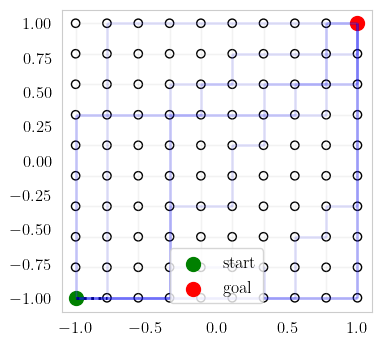

Acq optimizer x_next = (1, [0, 2, 11])
Finished iter i = 0
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 2.855798643897578
Found goal after visiting 53 vertices with estimated cost 1.8233523446085602
Found goal after visiting 98 vertices with estimated cost 1.6453590249472816
Found goal after visiting 100 vertices with estimated cost 2.618717925885206
Found goal after visiting 98 vertices with estimated cost 2.1412377823887914
Found goal after visiting 83 vertices with estimated cost 2.30729620366835
Found goal after visiting 92 vertices with estimated cost 1.3801723181502048
Found goal after visiting 83 vertices with estimated cost 1.7312436553662756
Found goal after visiting 100 vertices with estimated cost 3.174032501764546
Found goal after visiting 100 vertices with estimated cost 2.868908481757974
*[TIME] [Sample 10 execution paths] Elapsed: 24.65 sec

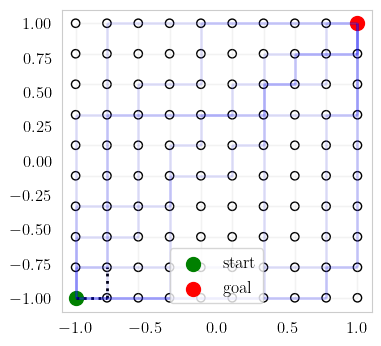

Acq optimizer x_next = (11, [1, 10, 12, 21])
Finished iter i = 1
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 98 vertices with estimated cost 2.1181260914084357
Found goal after visiting 68 vertices with estimated cost 2.4774747579648526
Found goal after visiting 86 vertices with estimated cost 2.9064464091243596
Found goal after visiting 98 vertices with estimated cost 3.2622649853222496
Found goal after visiting 69 vertices with estimated cost 2.0415287423099904
Found goal after visiting 87 vertices with estimated cost 2.817657984348802
Found goal after visiting 83 vertices with estimated cost 1.5334598158657824
Found goal after visiting 65 vertices with estimated cost 1.6597832463045679
Found goal after visiting 84 vertices with estimated cost 2.018849716056108
Found goal after visiting 80 vertices with estimated cost 3.08760641836486
*[TIME] [Sample 10 execution paths] Elapsed: 18.65

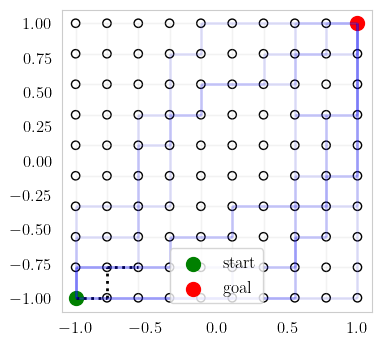

Acq optimizer x_next = (12, [2, 11, 13, 22])
Finished iter i = 2
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 88 vertices with estimated cost 2.9032422478369044
Found goal after visiting 77 vertices with estimated cost 2.007876557611299
Found goal after visiting 77 vertices with estimated cost 2.5184852516819625
Found goal after visiting 90 vertices with estimated cost 3.1243054098494487
Found goal after visiting 64 vertices with estimated cost 2.0550687864734174
Found goal after visiting 94 vertices with estimated cost 3.113060527130108
Found goal after visiting 82 vertices with estimated cost 2.8332393521991515
Found goal after visiting 99 vertices with estimated cost 2.7510232561046166
Found goal after visiting 79 vertices with estimated cost 3.08674967628304
Found goal after visiting 82 vertices with estimated cost 2.972780975970416
*[TIME] [Sample 10 execution paths] Elapsed: 18.86 

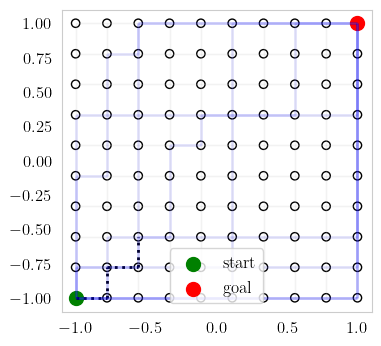

Acq optimizer x_next = (22, [12, 21, 23, 32])
Finished iter i = 3
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 95 vertices with estimated cost 2.837196944028176
Found goal after visiting 98 vertices with estimated cost 2.6381994086648
Found goal after visiting 75 vertices with estimated cost 2.433525968461853
Found goal after visiting 100 vertices with estimated cost 2.363444953052519
Found goal after visiting 80 vertices with estimated cost 2.0080274445570216
Found goal after visiting 93 vertices with estimated cost 2.1285090009395433
Found goal after visiting 69 vertices with estimated cost 2.21304767397512
Found goal after visiting 100 vertices with estimated cost 2.476029424692848
Found goal after visiting 83 vertices with estimated cost 2.2222599235247733
Found goal after visiting 82 vertices with estimated cost 1.932825488800795
*[TIME] [Sample 10 execution paths] Elapsed: 22.81 se

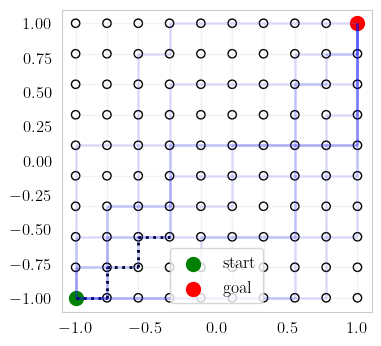

Acq optimizer x_next = (23, [13, 22, 24, 33])
Finished iter i = 4
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 87 vertices with estimated cost 2.455166471708586
Found goal after visiting 97 vertices with estimated cost 2.355273859506776
Found goal after visiting 100 vertices with estimated cost 2.444236391771476
Found goal after visiting 82 vertices with estimated cost 2.1842323146335523
Found goal after visiting 86 vertices with estimated cost 2.832069880023849
Found goal after visiting 91 vertices with estimated cost 2.132194480004169
Found goal after visiting 82 vertices with estimated cost 2.121936402052053
Found goal after visiting 93 vertices with estimated cost 2.7530671980686523
Found goal after visiting 98 vertices with estimated cost 3.2421668332700713
Found goal after visiting 100 vertices with estimated cost 2.351682734618602
*[TIME] [Sample 10 execution paths] Elapsed: 25.68

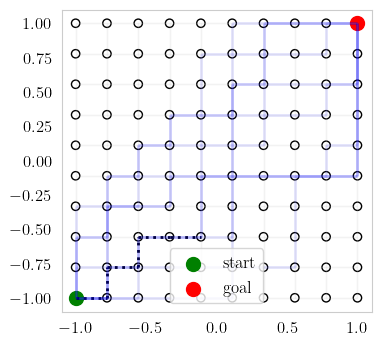

Acq optimizer x_next = (24, [14, 23, 25, 34])
Finished iter i = 5
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 96 vertices with estimated cost 2.308828194287176
Found goal after visiting 98 vertices with estimated cost 2.1936349361908536
Found goal after visiting 59 vertices with estimated cost 1.8148009044234426
Found goal after visiting 97 vertices with estimated cost 2.360344638043248
Found goal after visiting 97 vertices with estimated cost 2.2817946898515333
Found goal after visiting 100 vertices with estimated cost 2.3474667711913644
Found goal after visiting 100 vertices with estimated cost 3.508211578535669
Found goal after visiting 100 vertices with estimated cost 4.200028018867952
Found goal after visiting 99 vertices with estimated cost 2.5045882599075933
Found goal after visiting 100 vertices with estimated cost 3.8239131392332015
*[TIME] [Sample 10 execution paths] Elapsed: 

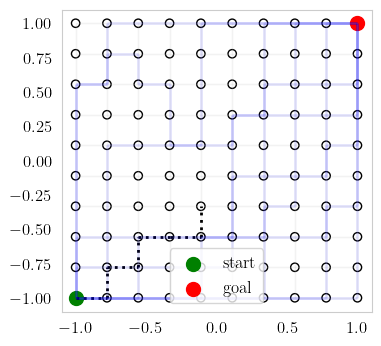

Acq optimizer x_next = (34, [24, 33, 35, 44])
Finished iter i = 6
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 81 vertices with estimated cost 2.2507000434103013
Found goal after visiting 100 vertices with estimated cost 3.038786258594713
Found goal after visiting 100 vertices with estimated cost 2.691048530669149
Found goal after visiting 90 vertices with estimated cost 1.9567356810166796
Found goal after visiting 100 vertices with estimated cost 2.28519041554448
Found goal after visiting 100 vertices with estimated cost 2.720314087693679
Found goal after visiting 82 vertices with estimated cost 1.7277570758077778
Found goal after visiting 100 vertices with estimated cost 2.3883005384192786
Found goal after visiting 100 vertices with estimated cost 2.9682966268449773
Found goal after visiting 100 vertices with estimated cost 2.4995808500840626
*[TIME] [Sample 10 execution paths] Elapsed

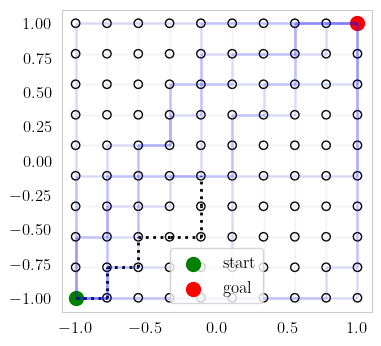

Acq optimizer x_next = (44, [34, 43, 45, 54])
Finished iter i = 7
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 97 vertices with estimated cost 2.9133041374925126
Found goal after visiting 91 vertices with estimated cost 2.2327642809057373
Found goal after visiting 97 vertices with estimated cost 2.256152137497171
Found goal after visiting 100 vertices with estimated cost 3.24925298175161
Found goal after visiting 98 vertices with estimated cost 2.9134916308865253
Found goal after visiting 87 vertices with estimated cost 1.942259416224234
Found goal after visiting 93 vertices with estimated cost 1.988441940985448
Found goal after visiting 71 vertices with estimated cost 1.8164113337234475
Found goal after visiting 100 vertices with estimated cost 2.916062464858502
Found goal after visiting 89 vertices with estimated cost 1.8674720420927906
*[TIME] [Sample 10 execution paths] Elapsed: 26.4

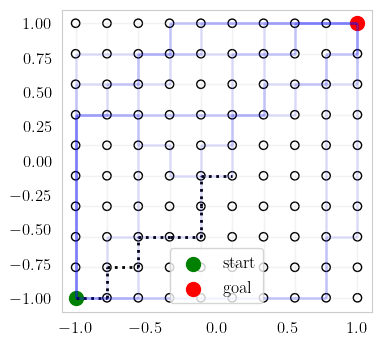

Acq optimizer x_next = (45, [35, 44, 46, 55])
Finished iter i = 8
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 2.206791490430261
Found goal after visiting 100 vertices with estimated cost 2.473636585453432
Found goal after visiting 82 vertices with estimated cost 2.047404406736766
Found goal after visiting 71 vertices with estimated cost 1.8930842822450231
Found goal after visiting 100 vertices with estimated cost 2.6020717334709786
Found goal after visiting 99 vertices with estimated cost 2.4140729583270057
Found goal after visiting 100 vertices with estimated cost 2.190015470572741
Found goal after visiting 85 vertices with estimated cost 2.0208676962133825
Found goal after visiting 92 vertices with estimated cost 2.1283474941044553
Found goal after visiting 73 vertices with estimated cost 1.7674468304333404
*[TIME] [Sample 10 execution paths] Elapsed: 

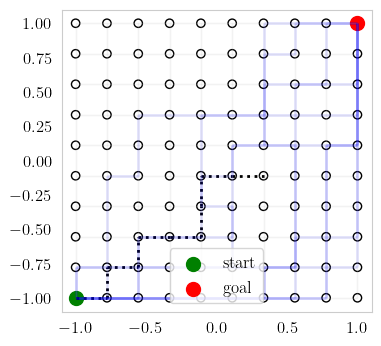

Acq optimizer x_next = (46, [36, 45, 47, 56])
Finished iter i = 9
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 88 vertices with estimated cost 1.9448350672694574
Found goal after visiting 62 vertices with estimated cost 1.503748539070234
Found goal after visiting 72 vertices with estimated cost 1.7643393379630419
Found goal after visiting 94 vertices with estimated cost 1.8549677740508244
Found goal after visiting 62 vertices with estimated cost 1.8787882447913522
Found goal after visiting 57 vertices with estimated cost 1.658329990344952
Found goal after visiting 100 vertices with estimated cost 2.1969178743175855
Found goal after visiting 100 vertices with estimated cost 2.374230545660033
Found goal after visiting 85 vertices with estimated cost 2.1538490178277088
Found goal after visiting 77 vertices with estimated cost 1.8124620953055046
*[TIME] [Sample 10 execution paths] Elapsed: 1

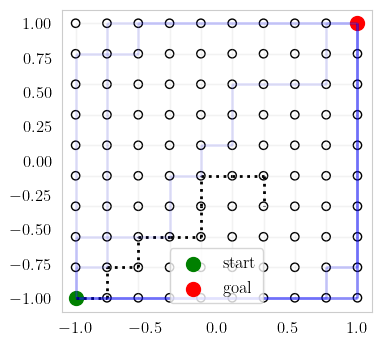

Acq optimizer x_next = (36, [26, 35, 37, 46])
Finished iter i = 10
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 70 vertices with estimated cost 1.9519385349670397
Found goal after visiting 69 vertices with estimated cost 1.6890400631170681
Found goal after visiting 100 vertices with estimated cost 2.2955714419457074
Found goal after visiting 100 vertices with estimated cost 2.041452657075785
Found goal after visiting 100 vertices with estimated cost 2.3612613608163353
Found goal after visiting 92 vertices with estimated cost 1.8657397036526797
Found goal after visiting 99 vertices with estimated cost 2.748499903810627
Found goal after visiting 73 vertices with estimated cost 1.8536033096501239
Found goal after visiting 98 vertices with estimated cost 2.0694493739919233
Found goal after visiting 93 vertices with estimated cost 2.1632114415724244
*[TIME] [Sample 10 execution paths] Elapsed

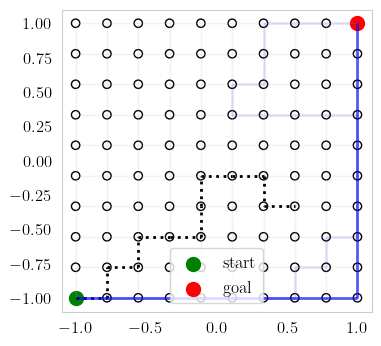

Acq optimizer x_next = (37, [27, 36, 38, 47])
Finished iter i = 11
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 95 vertices with estimated cost 2.523947858051333
Found goal after visiting 100 vertices with estimated cost 2.1273231519375466
Found goal after visiting 95 vertices with estimated cost 2.132465861787737
Found goal after visiting 96 vertices with estimated cost 1.9942625070689586
Found goal after visiting 99 vertices with estimated cost 1.9054767039217855
Found goal after visiting 62 vertices with estimated cost 1.694361182505316
Found goal after visiting 84 vertices with estimated cost 2.144263478482359
Found goal after visiting 100 vertices with estimated cost 2.735351123457046
Found goal after visiting 81 vertices with estimated cost 2.1826762487183555
Found goal after visiting 62 vertices with estimated cost 1.8220615832421605
*[TIME] [Sample 10 execution paths] Elapsed: 23

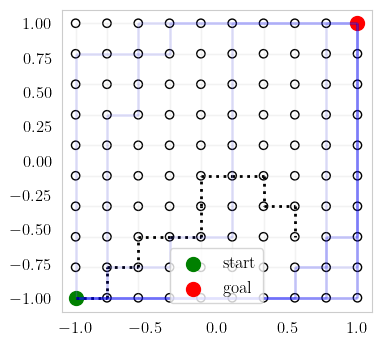

Acq optimizer x_next = (27, [17, 26, 28, 37])
Finished iter i = 12
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 96 vertices with estimated cost 1.980266539082179
Found goal after visiting 81 vertices with estimated cost 1.863859186520513
Found goal after visiting 100 vertices with estimated cost 2.3204856759107786
Found goal after visiting 93 vertices with estimated cost 2.4139253249791603
Found goal after visiting 94 vertices with estimated cost 2.5310110930314753
Found goal after visiting 94 vertices with estimated cost 2.4177564922871593
Found goal after visiting 97 vertices with estimated cost 1.9330585050921214
Found goal after visiting 100 vertices with estimated cost 3.1031166178920375
Found goal after visiting 78 vertices with estimated cost 2.0141506277966754
Found goal after visiting 82 vertices with estimated cost 1.9507081468587422
*[TIME] [Sample 10 execution paths] Elapsed:

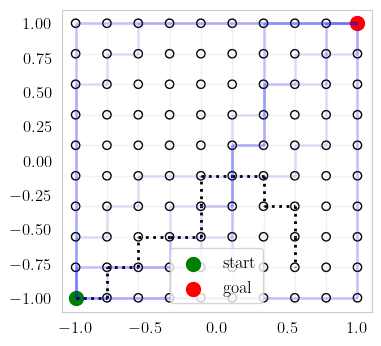

Acq optimizer x_next = (17, [7, 16, 18, 27])
Finished iter i = 13
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 89 vertices with estimated cost 2.2822275157503835
Found goal after visiting 92 vertices with estimated cost 2.2511995584056126
Found goal after visiting 99 vertices with estimated cost 2.1055936049232753
Found goal after visiting 90 vertices with estimated cost 1.8314724382398824
Found goal after visiting 99 vertices with estimated cost 2.4281330215037857
Found goal after visiting 70 vertices with estimated cost 1.984053677795885
Found goal after visiting 92 vertices with estimated cost 2.251060168515779
Found goal after visiting 99 vertices with estimated cost 2.7477101678099594
Found goal after visiting 100 vertices with estimated cost 2.9737716971710846
Found goal after visiting 46 vertices with estimated cost 1.6415527877780232
*[TIME] [Sample 10 execution paths] Elapsed: 2

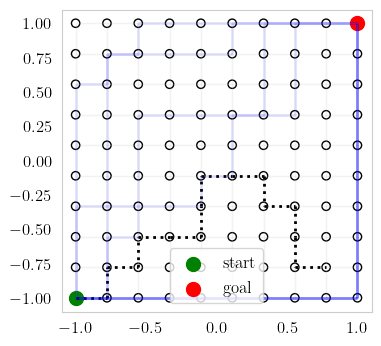

Acq optimizer x_next = (18, [8, 17, 19, 28])
Finished iter i = 14
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 2.7421389497078117
Found goal after visiting 100 vertices with estimated cost 2.6031727553303936
Found goal after visiting 100 vertices with estimated cost 3.1907758742576604
Found goal after visiting 96 vertices with estimated cost 2.616280570283977
Found goal after visiting 100 vertices with estimated cost 3.5597919786726333
Found goal after visiting 85 vertices with estimated cost 2.2782717010167626
Found goal after visiting 100 vertices with estimated cost 2.5022163638797243
Found goal after visiting 100 vertices with estimated cost 2.5946394753967343
Found goal after visiting 100 vertices with estimated cost 2.705810409643262
Found goal after visiting 98 vertices with estimated cost 2.843418989732366
*[TIME] [Sample 10 execution paths] Elaps

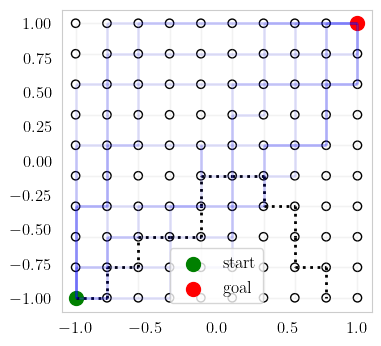

Acq optimizer x_next = (8, [7, 9, 18])
Finished iter i = 15
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 98 vertices with estimated cost 2.7648657549625177
Found goal after visiting 100 vertices with estimated cost 2.8896821164292907
Found goal after visiting 96 vertices with estimated cost 2.8365752962327644
Found goal after visiting 91 vertices with estimated cost 2.182755019489017
Found goal after visiting 87 vertices with estimated cost 2.218097851932755
Found goal after visiting 100 vertices with estimated cost 2.7098290160185594
Found goal after visiting 82 vertices with estimated cost 2.0466476954363806
Found goal after visiting 100 vertices with estimated cost 3.2535211543094023
Found goal after visiting 99 vertices with estimated cost 2.588479677204946
Found goal after visiting 100 vertices with estimated cost 3.1825381622540645
*[TIME] [Sample 10 execution paths] Elapsed: 29.89

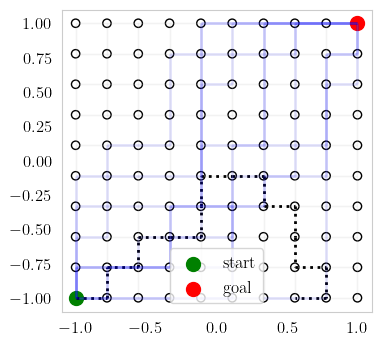

Acq optimizer x_next = (7, [6, 8, 17])
Finished iter i = 16
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.064805814603046
Found goal after visiting 94 vertices with estimated cost 2.4725517715560827
Found goal after visiting 94 vertices with estimated cost 2.526420067307331
Found goal after visiting 93 vertices with estimated cost 2.565448999998341
Found goal after visiting 94 vertices with estimated cost 2.5279889507537465
Found goal after visiting 100 vertices with estimated cost 2.9762987071496068
Found goal after visiting 100 vertices with estimated cost 3.5443331954663777
Found goal after visiting 100 vertices with estimated cost 2.7152410512717546
Found goal after visiting 95 vertices with estimated cost 2.628998766576687
Found goal after visiting 100 vertices with estimated cost 2.9425886557651326
*[TIME] [Sample 10 execution paths] Elapsed: 31.61

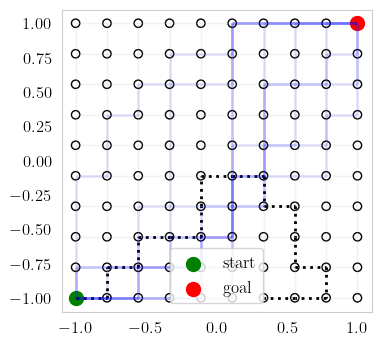

Acq optimizer x_next = (6, [5, 7, 16])
Finished iter i = 17
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 68 vertices with estimated cost 2.02566744331224
Found goal after visiting 100 vertices with estimated cost 3.0814376035041797
Found goal after visiting 94 vertices with estimated cost 2.6578772515956652
Found goal after visiting 74 vertices with estimated cost 1.8939059779865963
Found goal after visiting 94 vertices with estimated cost 2.5788558992053114
Found goal after visiting 100 vertices with estimated cost 2.792320241366575
Found goal after visiting 97 vertices with estimated cost 2.659420096367789
Found goal after visiting 94 vertices with estimated cost 2.6857518847238544
Found goal after visiting 100 vertices with estimated cost 3.1717276292307295
Found goal after visiting 100 vertices with estimated cost 2.9712521161870598
*[TIME] [Sample 10 execution paths] Elapsed: 28.38 

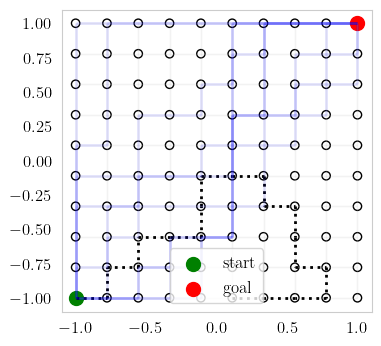

Acq optimizer x_next = (5, [4, 6, 15])
Finished iter i = 18
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 2.7476290484726773
Found goal after visiting 100 vertices with estimated cost 2.8335299404662755
Found goal after visiting 92 vertices with estimated cost 2.317299363103741
Found goal after visiting 100 vertices with estimated cost 3.145733402593899
Found goal after visiting 92 vertices with estimated cost 2.4717245308559694
Found goal after visiting 100 vertices with estimated cost 2.763696756542442
Found goal after visiting 86 vertices with estimated cost 2.16678270205332
Found goal after visiting 88 vertices with estimated cost 1.9331355715659002
Found goal after visiting 94 vertices with estimated cost 2.533331650005501
Found goal after visiting 97 vertices with estimated cost 2.751873598343541
*[TIME] [Sample 10 execution paths] Elapsed: 29.98 sec

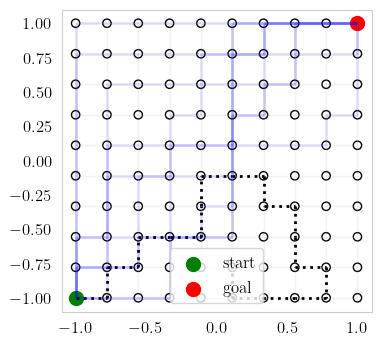

Acq optimizer x_next = (15, [5, 14, 16, 25])
Finished iter i = 19
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.305606282042896
Found goal after visiting 89 vertices with estimated cost 2.432247043087424
Found goal after visiting 94 vertices with estimated cost 2.5208494960123837
Found goal after visiting 88 vertices with estimated cost 2.2214149567644177
Found goal after visiting 86 vertices with estimated cost 2.0688303971612774
Found goal after visiting 100 vertices with estimated cost 3.356153728184643
Found goal after visiting 80 vertices with estimated cost 1.852500899863711
Found goal after visiting 93 vertices with estimated cost 2.4700802741054773
Found goal after visiting 92 vertices with estimated cost 2.493780293859476
Found goal after visiting 99 vertices with estimated cost 2.759573916561069
*[TIME] [Sample 10 execution paths] Elapsed: 27.5

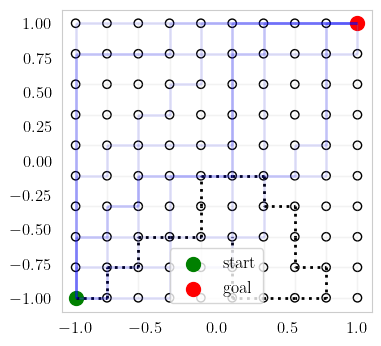

Acq optimizer x_next = (25, [15, 24, 26, 35])
Finished iter i = 20
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.2961597537657403
Found goal after visiting 90 vertices with estimated cost 2.122487331062473
Found goal after visiting 82 vertices with estimated cost 2.1091615782201685
Found goal after visiting 97 vertices with estimated cost 2.4517888331448856
Found goal after visiting 100 vertices with estimated cost 3.1962747933521136
Found goal after visiting 92 vertices with estimated cost 2.313788896446839
Found goal after visiting 100 vertices with estimated cost 2.791148207759978
Found goal after visiting 100 vertices with estimated cost 2.6657874507818393
Found goal after visiting 97 vertices with estimated cost 2.6817868438831494
Found goal after visiting 88 vertices with estimated cost 2.2859920667334377
*[TIME] [Sample 10 execution paths] Elapsed

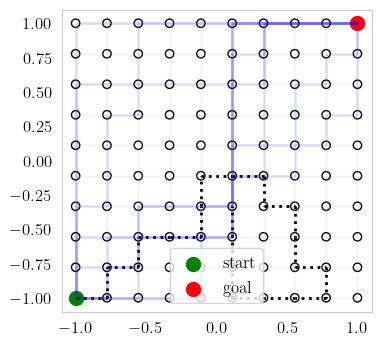

Acq optimizer x_next = (35, [25, 34, 36, 45])
Finished iter i = 21
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 87 vertices with estimated cost 1.8901032912838365
Found goal after visiting 85 vertices with estimated cost 1.869821842920656
Found goal after visiting 100 vertices with estimated cost 3.245112812613375
Found goal after visiting 100 vertices with estimated cost 2.8308080648684144
Found goal after visiting 100 vertices with estimated cost 2.9190621568782538
Found goal after visiting 100 vertices with estimated cost 2.8150263647531135
Found goal after visiting 94 vertices with estimated cost 2.6678978216941127
Found goal after visiting 92 vertices with estimated cost 2.2724339684288504
Found goal after visiting 99 vertices with estimated cost 2.8615070354091054
Found goal after visiting 90 vertices with estimated cost 2.036679725421235
*[TIME] [Sample 10 execution paths] Elapsed

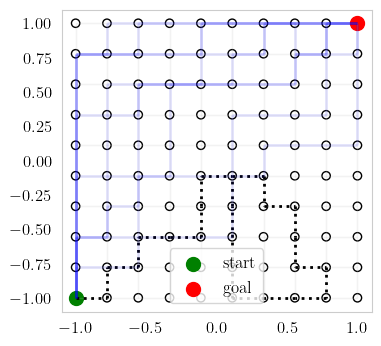

Acq optimizer x_next = (45, [35, 44, 46, 55])
Finished iter i = 22
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 94 vertices with estimated cost 2.6382505487476107
Found goal after visiting 90 vertices with estimated cost 2.343520250665739
Found goal after visiting 89 vertices with estimated cost 2.1719507849428954
Found goal after visiting 99 vertices with estimated cost 2.8793089261611327
Found goal after visiting 94 vertices with estimated cost 2.4010693205090985
Found goal after visiting 89 vertices with estimated cost 2.412328399544858
Found goal after visiting 95 vertices with estimated cost 2.6470479846986827
Found goal after visiting 94 vertices with estimated cost 2.5110497742830207
Found goal after visiting 95 vertices with estimated cost 2.7335838259279592
Found goal after visiting 100 vertices with estimated cost 2.7328891573625205
*[TIME] [Sample 10 execution paths] Elapsed: 

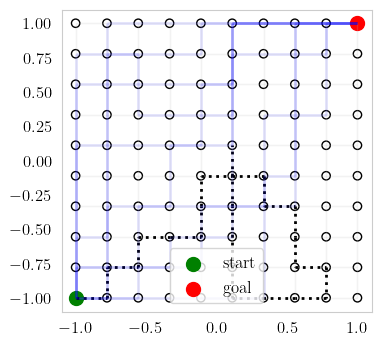

Acq optimizer x_next = (55, [45, 54, 56, 65])
Finished iter i = 23
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 67 vertices with estimated cost 1.6561970864099755
Found goal after visiting 95 vertices with estimated cost 2.177708310074314
Found goal after visiting 82 vertices with estimated cost 1.9132341364080125
Found goal after visiting 87 vertices with estimated cost 2.1957085480606042
Found goal after visiting 100 vertices with estimated cost 2.789131119669209
Found goal after visiting 86 vertices with estimated cost 1.8069231288475665
Found goal after visiting 82 vertices with estimated cost 2.113462566014027
Found goal after visiting 96 vertices with estimated cost 2.7142416316087368
Found goal after visiting 100 vertices with estimated cost 3.2431768342192875
Found goal after visiting 99 vertices with estimated cost 2.570527889483348
*[TIME] [Sample 10 execution paths] Elapsed: 2

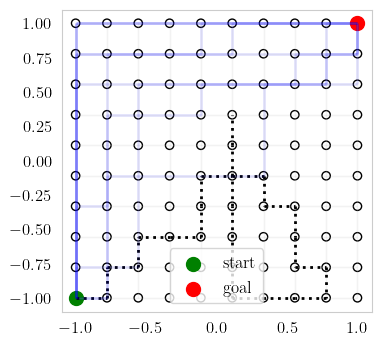

Acq optimizer x_next = (65, [55, 64, 66, 75])
Finished iter i = 24
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 91 vertices with estimated cost 2.4683031682834478
Found goal after visiting 81 vertices with estimated cost 2.0398728676275697
Found goal after visiting 92 vertices with estimated cost 2.4598208217998296
Found goal after visiting 75 vertices with estimated cost 1.926103481084069
Found goal after visiting 99 vertices with estimated cost 2.7862567442222
Found goal after visiting 47 vertices with estimated cost 1.4233724044163873
Found goal after visiting 90 vertices with estimated cost 2.454388008731092
Found goal after visiting 90 vertices with estimated cost 2.033450852065355
Found goal after visiting 99 vertices with estimated cost 2.648032658384001
Found goal after visiting 95 vertices with estimated cost 2.65650267606744
*[TIME] [Sample 10 execution paths] Elapsed: 24.45 se

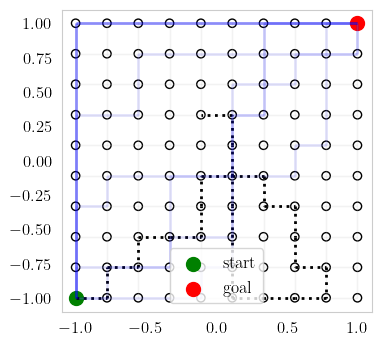

Acq optimizer x_next = (64, [54, 63, 65, 74])
Finished iter i = 25
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 44 vertices with estimated cost 1.520130612142461
Found goal after visiting 81 vertices with estimated cost 2.0216268047428434
Found goal after visiting 90 vertices with estimated cost 2.141710105576399
Found goal after visiting 69 vertices with estimated cost 1.7944777995964551
Found goal after visiting 89 vertices with estimated cost 2.14909037681339
Found goal after visiting 83 vertices with estimated cost 1.9456971753783985
Found goal after visiting 99 vertices with estimated cost 2.83448645253824
Found goal after visiting 94 vertices with estimated cost 2.469242710333362
Found goal after visiting 96 vertices with estimated cost 2.6283228115039217
Found goal after visiting 100 vertices with estimated cost 2.956985707810454
*[TIME] [Sample 10 execution paths] Elapsed: 22.44 

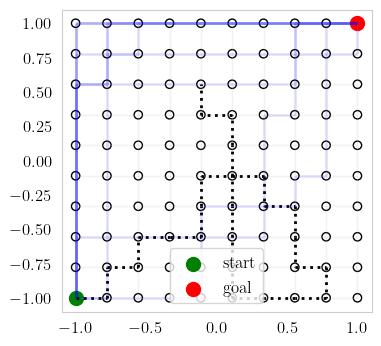

Acq optimizer x_next = (74, [64, 73, 75, 84])
Finished iter i = 26
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 81 vertices with estimated cost 1.9951560919831623
Found goal after visiting 95 vertices with estimated cost 2.1736980074182135
Found goal after visiting 94 vertices with estimated cost 2.2505838827267644
Found goal after visiting 80 vertices with estimated cost 2.0396779244108965
Found goal after visiting 42 vertices with estimated cost 1.3612610503866598
Found goal after visiting 87 vertices with estimated cost 2.2064455956760645
Found goal after visiting 62 vertices with estimated cost 1.6918601548617387
Found goal after visiting 66 vertices with estimated cost 1.6567496747061374
Found goal after visiting 88 vertices with estimated cost 2.282440909870367
Found goal after visiting 96 vertices with estimated cost 2.768335141957476
*[TIME] [Sample 10 execution paths] Elapsed: 1

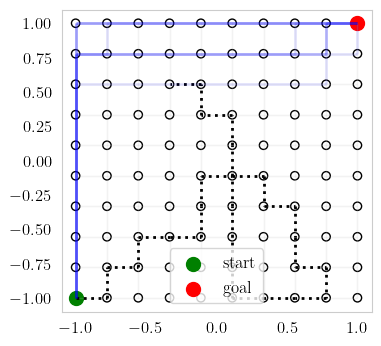

Acq optimizer x_next = (73, [63, 72, 74, 83])
Finished iter i = 27
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 87 vertices with estimated cost 2.144818951490994
Found goal after visiting 71 vertices with estimated cost 1.7881973836417504
Found goal after visiting 86 vertices with estimated cost 2.2558040392013163
Found goal after visiting 80 vertices with estimated cost 2.0360959721763447
Found goal after visiting 87 vertices with estimated cost 2.0891750333960863
Found goal after visiting 79 vertices with estimated cost 1.9776003450334365
Found goal after visiting 100 vertices with estimated cost 2.873307782595836
Found goal after visiting 85 vertices with estimated cost 2.3547435855067445
Found goal after visiting 94 vertices with estimated cost 2.5749104183880203
Found goal after visiting 80 vertices with estimated cost 2.180773722343365
*[TIME] [Sample 10 execution paths] Elapsed: 2

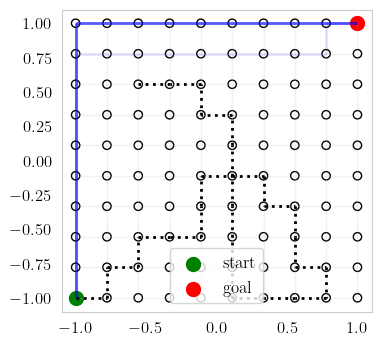

Acq optimizer x_next = (72, [62, 71, 73, 82])
Finished iter i = 28
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 95 vertices with estimated cost 2.454043726931453
Found goal after visiting 93 vertices with estimated cost 2.269179501371932
Found goal after visiting 100 vertices with estimated cost 2.938660053047781
Found goal after visiting 94 vertices with estimated cost 2.667447598254114
Found goal after visiting 91 vertices with estimated cost 2.4789679846159993
Found goal after visiting 78 vertices with estimated cost 2.007295096289384
Found goal after visiting 89 vertices with estimated cost 2.3155645310479773
Found goal after visiting 92 vertices with estimated cost 2.3526009255903895
Found goal after visiting 85 vertices with estimated cost 2.230916575534876
Found goal after visiting 100 vertices with estimated cost 2.8721240142638136
*[TIME] [Sample 10 execution paths] Elapsed: 27.

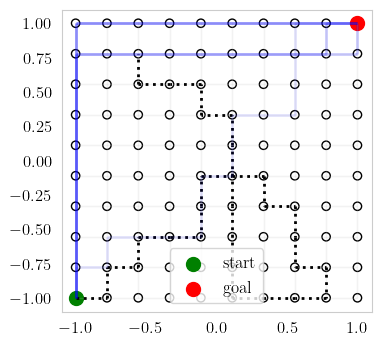

Acq optimizer x_next = (82, [72, 81, 83, 92])
Finished iter i = 29
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 2.9180429274265
Found goal after visiting 100 vertices with estimated cost 3.065030579125263
Found goal after visiting 100 vertices with estimated cost 3.18480447093593
Found goal after visiting 93 vertices with estimated cost 2.5248803837013947
Found goal after visiting 93 vertices with estimated cost 2.6368883853374046
Found goal after visiting 95 vertices with estimated cost 2.3502186594196752
Found goal after visiting 100 vertices with estimated cost 2.649986311274661
Found goal after visiting 91 vertices with estimated cost 2.558241424185962
Found goal after visiting 88 vertices with estimated cost 2.3409394647322403
Found goal after visiting 95 vertices with estimated cost 2.5233463106018132
*[TIME] [Sample 10 execution paths] Elapsed: 31.

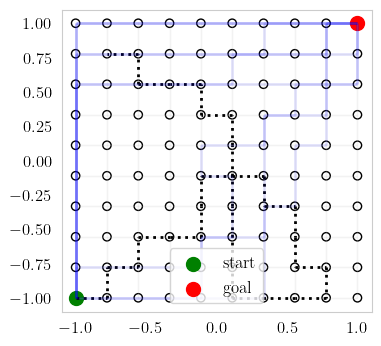

Acq optimizer x_next = (81, [71, 80, 82, 91])
Finished iter i = 30
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 92 vertices with estimated cost 2.6716706021391516
Found goal after visiting 99 vertices with estimated cost 2.7320103440943306
Found goal after visiting 90 vertices with estimated cost 2.4905396222687957
Found goal after visiting 85 vertices with estimated cost 2.4053527709414793
Found goal after visiting 92 vertices with estimated cost 2.668953194508566
Found goal after visiting 100 vertices with estimated cost 2.8461816377489173
Found goal after visiting 90 vertices with estimated cost 2.6851145795665627
Found goal after visiting 100 vertices with estimated cost 2.823906135552507
Found goal after visiting 100 vertices with estimated cost 2.862357768225847
Found goal after visiting 100 vertices with estimated cost 2.8558268836919645
*[TIME] [Sample 10 execution paths] Elapsed

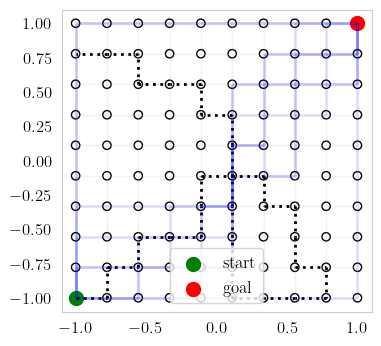

Acq optimizer x_next = (80, [70, 81, 90])
Finished iter i = 31
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 86 vertices with estimated cost 2.3179077153181327
Found goal after visiting 92 vertices with estimated cost 2.5931071918078974
Found goal after visiting 92 vertices with estimated cost 2.6616508455770393
Found goal after visiting 91 vertices with estimated cost 2.6276663454043754
Found goal after visiting 100 vertices with estimated cost 2.68936394912555
Found goal after visiting 100 vertices with estimated cost 2.8738904758383894
Found goal after visiting 87 vertices with estimated cost 2.376416561713313
Found goal after visiting 100 vertices with estimated cost 2.9580622617395496
Found goal after visiting 91 vertices with estimated cost 2.442491420039455
Found goal after visiting 91 vertices with estimated cost 2.448819155567055
*[TIME] [Sample 10 execution paths] Elapsed: 29.72

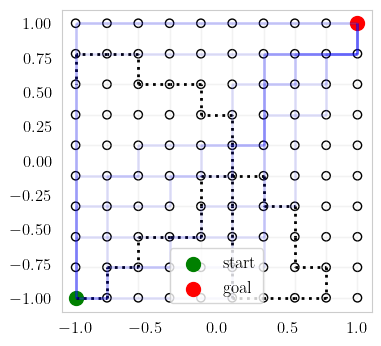

Acq optimizer x_next = (70, [60, 71, 80])
Finished iter i = 32
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 100 vertices with estimated cost 3.3230242776476118
Found goal after visiting 82 vertices with estimated cost 2.3590669630681975
Found goal after visiting 100 vertices with estimated cost 2.794634241732401
Found goal after visiting 86 vertices with estimated cost 2.331992637284114
Found goal after visiting 97 vertices with estimated cost 2.7497521823648925
Found goal after visiting 96 vertices with estimated cost 2.658033427346088
Found goal after visiting 86 vertices with estimated cost 2.4066657521380854
Found goal after visiting 100 vertices with estimated cost 3.048529697809556
Found goal after visiting 94 vertices with estimated cost 2.5781147291195343
Found goal after visiting 100 vertices with estimated cost 3.091329630710332
*[TIME] [Sample 10 execution paths] Elapsed: 30.8

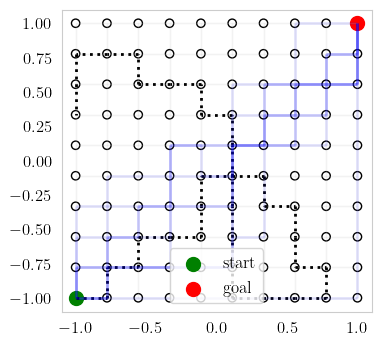

Acq optimizer x_next = (60, [50, 61, 70])
Finished iter i = 33
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 96 vertices with estimated cost 2.78474998410993
Found goal after visiting 100 vertices with estimated cost 2.8637387660095586
Found goal after visiting 100 vertices with estimated cost 3.0279680624129526
Found goal after visiting 98 vertices with estimated cost 2.701900897111099
Found goal after visiting 90 vertices with estimated cost 2.664247774909761
Found goal after visiting 97 vertices with estimated cost 2.7907918203208055
Found goal after visiting 91 vertices with estimated cost 2.608552387080795
Found goal after visiting 100 vertices with estimated cost 2.9746671967369758
Found goal after visiting 100 vertices with estimated cost 3.2443187182730755
Found goal after visiting 100 vertices with estimated cost 3.3474832989243715
*[TIME] [Sample 10 execution paths] Elapsed: 33.

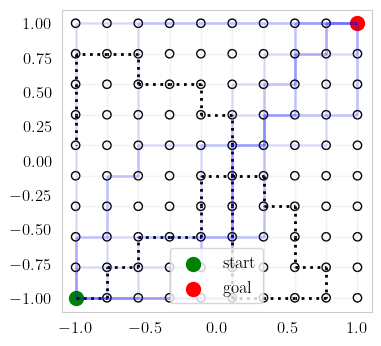

Acq optimizer x_next = (50, [40, 51, 60])
Finished iter i = 34
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 95 vertices with estimated cost 2.557266475917568
Found goal after visiting 100 vertices with estimated cost 3.0564846290532204
Found goal after visiting 90 vertices with estimated cost 2.624339891402629
Found goal after visiting 100 vertices with estimated cost 2.9629939868497726
Found goal after visiting 100 vertices with estimated cost 3.2852938508366556
Found goal after visiting 100 vertices with estimated cost 2.939258329906701
Found goal after visiting 95 vertices with estimated cost 2.72398851534155
Found goal after visiting 92 vertices with estimated cost 2.5906719567196226
Found goal after visiting 97 vertices with estimated cost 2.730879819539976
Found goal after visiting 94 vertices with estimated cost 2.7045313612741424
*[TIME] [Sample 10 execution paths] Elapsed: 33.29

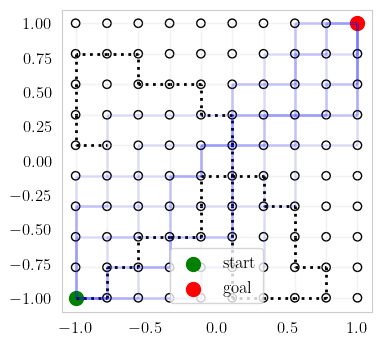

Acq optimizer x_next = (51, [41, 50, 52, 61])
Finished iter i = 35
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 90 vertices with estimated cost 2.523967729260281
Found goal after visiting 100 vertices with estimated cost 3.3205732304822453
Found goal after visiting 93 vertices with estimated cost 2.466571689426817
Found goal after visiting 92 vertices with estimated cost 2.5992907350329477
Found goal after visiting 100 vertices with estimated cost 2.8784520740554647
Found goal after visiting 89 vertices with estimated cost 2.5392495181796533
Found goal after visiting 91 vertices with estimated cost 2.4766380467795974
Found goal after visiting 100 vertices with estimated cost 2.871062241147938
Found goal after visiting 100 vertices with estimated cost 3.135923500448873
Found goal after visiting 91 vertices with estimated cost 2.530870054483194
*[TIME] [Sample 10 execution paths] Elapsed: 

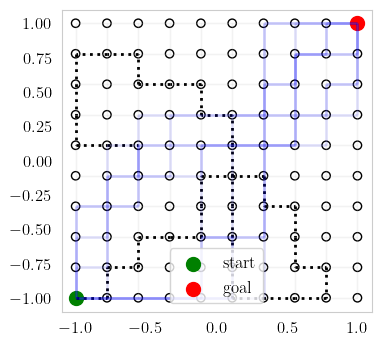

Acq optimizer x_next = (52, [42, 51, 53, 62])
Finished iter i = 36
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 90 vertices with estimated cost 2.478864061641204
Found goal after visiting 89 vertices with estimated cost 2.5594834312275374
Found goal after visiting 100 vertices with estimated cost 2.74034305646808
Found goal after visiting 90 vertices with estimated cost 2.709322636642756
Found goal after visiting 91 vertices with estimated cost 2.6080557644675135
Found goal after visiting 100 vertices with estimated cost 2.955746192881538
Found goal after visiting 100 vertices with estimated cost 2.769201450095945
Found goal after visiting 100 vertices with estimated cost 3.115247711964639
Found goal after visiting 100 vertices with estimated cost 2.8406258416098473
Found goal after visiting 100 vertices with estimated cost 2.964687973431791
*[TIME] [Sample 10 execution paths] Elapsed: 3

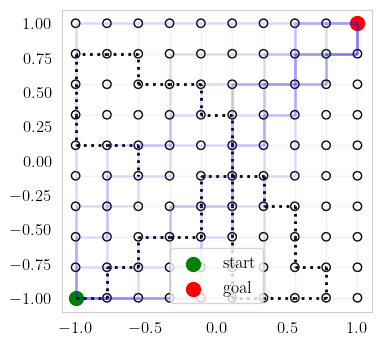

Acq optimizer x_next = (42, [32, 41, 43, 52])
Finished iter i = 37
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 91 vertices with estimated cost 2.5864651598280166
Found goal after visiting 95 vertices with estimated cost 2.757123805094926
Found goal after visiting 100 vertices with estimated cost 3.2648747175766717
Found goal after visiting 90 vertices with estimated cost 2.5575293883478367
Found goal after visiting 100 vertices with estimated cost 2.980599223198479
Found goal after visiting 91 vertices with estimated cost 2.503647950771879
Found goal after visiting 89 vertices with estimated cost 2.5563339736183197
Found goal after visiting 100 vertices with estimated cost 2.7949490026676984
Found goal after visiting 100 vertices with estimated cost 2.7808522642986073
Found goal after visiting 100 vertices with estimated cost 2.733311849916908
*[TIME] [Sample 10 execution paths] Elapsed

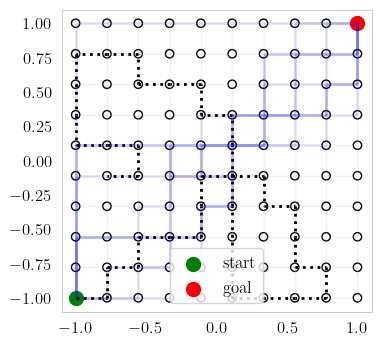

Acq optimizer x_next = (41, [31, 40, 42, 51])
Finished iter i = 38
*[INFO] AcqOptimizer with params=Namespace(acq_str='exe', n_path=10, name='AcqOptimizer', opt_str='rs', viz_acq=False)
Found goal after visiting 98 vertices with estimated cost 2.754720307387215
Found goal after visiting 93 vertices with estimated cost 2.5993336069418604
Found goal after visiting 100 vertices with estimated cost 3.2530086004595375
Found goal after visiting 100 vertices with estimated cost 2.8341428978977565
Found goal after visiting 100 vertices with estimated cost 2.89082611217978
Found goal after visiting 100 vertices with estimated cost 3.15020960965139
Found goal after visiting 91 vertices with estimated cost 2.6057760753627863
Found goal after visiting 99 vertices with estimated cost 2.759833249653798
Found goal after visiting 90 vertices with estimated cost 2.46485233036674
Found goal after visiting 100 vertices with estimated cost 2.754358256856924
*[TIME] [Sample 10 execution paths] Elapsed: 34.

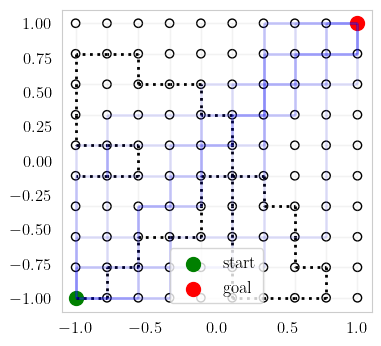

Acq optimizer x_next = (40, [30, 41, 50])
Finished iter i = 39


In [12]:
# BAX iterations
import time

n_iter = 40

def possible_steps(vertex: Vertex):
    neighbors = vertex.neighbors
    possible_positions = np.stack([n.position for n in neighbors])
    return possible_positions

current_path = [start]
x_test = possible_steps(start)

for i in range(n_iter):
    # Optimize acquisition function
    acqopt = AcqOptimizer({'n_path': 10,
                           'viz_acq': False})
    arg_x_next = acqopt.optimize(model, algo, x_test, return_argmax=True)

    # Query function, update data
    x_next = x_test[arg_x_next]
    y_next = f(x_next)
    data.x.append(x_next)
    data.y.append(y_next)
    
    # Update physical path taken
    next_vertex = current_path[-1].neighbors[arg_x_next]
    current_path.append(next_vertex)
    #print(f"Incurred true cost so far: {cost_of_path(current_path, cost_func)}")
    
    # Update next set of x_test    
    x_test = possible_steps(next_vertex)

    # Update model
    model = SimpleGp(gp_params)
    model.set_data(data)
    
    fig, ax = plot_progress(edges, start, goal, current_path)
    
    last_outputs = acqopt.get_last_output_list()
    min_costs, min_cost_paths = zip(*last_outputs)
    n = acqopt.params.n_path
    for path in min_cost_paths:
        plot_path(ax, path, path_color=(0, 0, 1, 1/n), linewidths=2, linestyle="-")
    
    # make matplotlib plot within for loop. See: https://stackoverflow.com/questions/19766100/real-time-matplotlib-plot-is-not-working-while-still-in-a-loop
    plt.pause(0.0001)
    
    print(f'Acq optimizer x_next = {next_vertex}')
    print(f'Finished iter i = {i}')